In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skl2onnx import to_onnx
from onnxruntime import InferenceSession
%matplotlib inline

/Users/minhpham1606/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the data
data_path = "filled_data.csv"
data = pd.read_csv(data_path)

# Extract the relevant columns
datetime_column = pd.to_datetime(data['datetime'])
# Get all feature columns except 'datetime'
feature_columns = data.columns[1:]  # Exclude the 'datetime' column
from challenge_utils import build_training_data

# Data Exploration

In [3]:
print(data.shape)
data.head()

(17520, 28)


,datetime,AirTemp,pres,rain,rh,wd,ws,Global_Solar_Flux,Diffuse_Solar_Flux,Direct_Solar_Flux,...,kw_heatingcoolingtotal_zone1,kw_heatingcoolingtotal_zone2,kw_lights_zone1,kw_lights_zone2,kw_total_zone1,kw_total_zone2,kw_ventilation_zone1,kw_ventilation_zone2,kw_water_heater_zone2,plugs_zone2
0,2022-01-01 00:00:00+00:00,10.279,1005.058,0.000,95.870,187.576,1.758,-0.271,-0.370,-0.110,...,-1.798,-2.037,-0.002,-0.222,2.091,2.308,-0.027,-0.030,-0.004,-0.156
1,2022-01-01 01:00:00+00:00,10.318,1004.790,0.000,95.335,218.280,2.401,-0.371,-0.499,-0.231,...,-1.794,-2.170,-0.002,-0.278,2.086,2.504,-0.027,-0.044,-0.004,-0.157
2,2022-01-01 02:00:00+00:00,9.901,1004.791,0.013,95.699,185.351,1.821,-0.846,-0.999,-0.235,...,-1.795,-2.202,-0.002,-0.238,2.085,2.501,-0.026,-0.043,-0.004,-0.157
3,2022-01-01 03:00:00+00:00,9.444,1004.554,0.000,95.881,193.537,1.760,-0.632,-0.755,-0.173,...,-1.811,-2.238,-0.002,-0.240,2.100,2.539,-0.026,-0.044,-0.004,-0.157
4,2022-01-01 04:00:00+00:00,8.587,1004.524,0.000,96.738,174.806,1.613,-0.395,-0.489,-0.110,...,-1.814,-2.287,-0.002,-0.280,2.102,2.952,-0.027,-0.044,-0.356,-0.156


In [4]:
cor_matrix = data.corr()
# cor_matrix
col = "kw_total_zone2"
sort_col_matrix = cor_matrix.sort_values(col, ascending=False)[col]
selected_feature = [x for x in sort_col_matrix.index if abs(sort_col_matrix[x]) > 0.2 and x != col]
# print(sort_col_matrix)
print(sort_col_matrix[selected_feature])

TGBT [kW]                       0.789724
kw_total_zone1                  0.774803
plugs_zone2                    -0.235851
Downwelling_IR_Flux            -0.303648
kw_ventilation_zone2           -0.429452
kw_lights_zone1                -0.436811
kw_water_heater_zone2          -0.453275
kw_heater_corridor1_zone1      -0.457505
kw_lights_zone2                -0.469217
kw_heaters_toilets_zone2       -0.495002
AirTemp                        -0.500274
kw_ventilation_zone1           -0.529241
kw_heaters_corridor_zone2      -0.582653
kw_heatingcoolingtotal_zone1   -0.682820
kw_heatingcoolingtotal_zone2   -0.853121
Name: kw_total_zone2, dtype: float64


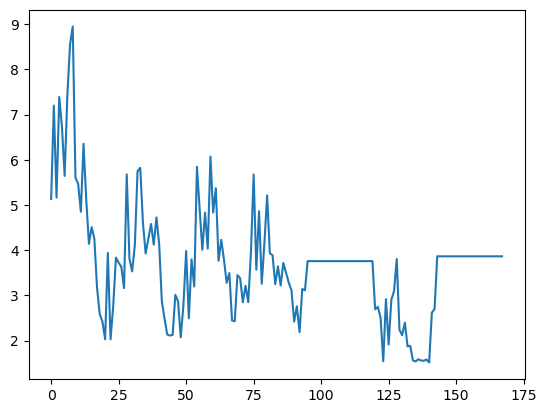

In [6]:
day_start = 100
kw_zone2 = data["kw_total_zone2"][24*day_start:24*(day_start + 7)]
import matplotlib.pyplot as plt 
plt.plot(range(len(kw_zone2)), kw_zone2, label="kw_zone2_hourly")
# plt.figure(figsize=(20, 10))

In [25]:
feature_zone_2 = [x for x in selected_feature if "zone1" not in x]
print(feature_zone_2)
features = ["plugs_zone2", "kw_ventilation_zone2", "kw_water_heater_zone2", "kw_lights_zone2", "kw_heaters_toilets_zone2", "kw_heaters_corridor_zone2", "kw_heatingcoolingtotal_zone2", "kw_total_zone2"]

['TGBT [kW]', 'plugs_zone2', 'Downwelling_IR_Flux', 'kw_ventilation_zone2', 'kw_water_heater_zone2', 'kw_lights_zone2', 'kw_heaters_toilets_zone2', 'AirTemp', 'kw_heaters_corridor_zone2', 'kw_heatingcoolingtotal_zone2']


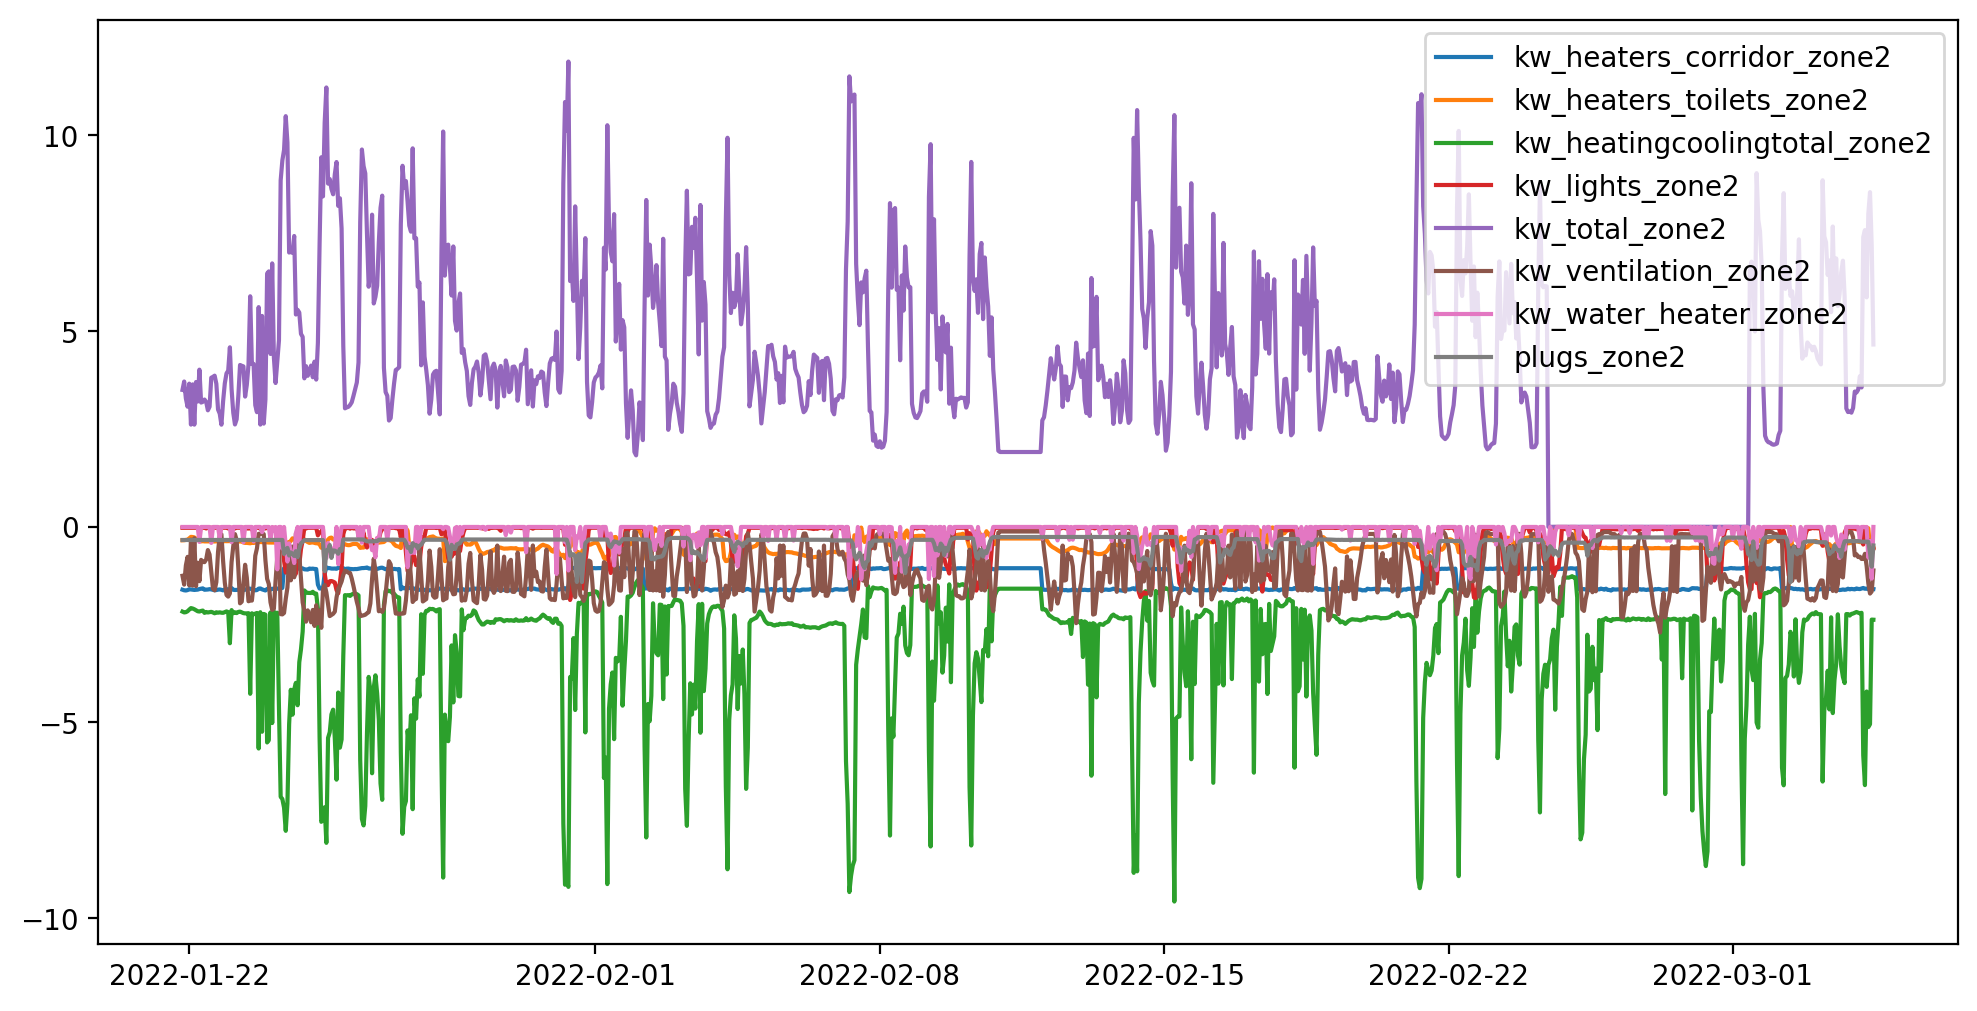

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=200)

time = data['datetime'].astype(np.datetime64).values.astype('datetime64[s]')

# slicing out a few months of data
start = 500
some = slice(start, start + 1000)

for col in data.columns[1::]:

    # only plotting a few variables
    if col in features:
        ax.plot(time[some], data[col].values[some], label=col)

ax.legend()

Why are there some negative features? How can the consumption be negative? \\
Why is there a part of zeros for kw_total_zone2 between 22-02 to 01-03-2022?
- Did they shut down the whole building?
- The measure doesn't working?
- They took out the data?

In [42]:
pd.set_option('display.max_rows', df.shape[0])
data["kw_total_zone2"][data["kw_total_zone2"] == 0]

1307     0.0
1308     0.0
1309     0.0
1310     0.0
1311     0.0
1312     0.0
1313     0.0
1314     0.0
1315     0.0
1316     0.0
1317     0.0
1318     0.0
1319     0.0
1320     0.0
1321     0.0
1322     0.0
1323     0.0
1324     0.0
1325     0.0
1326     0.0
1327     0.0
1328     0.0
1329     0.0
1330     0.0
1331     0.0
1332     0.0
1333     0.0
1334     0.0
1335     0.0
1336     0.0
1337     0.0
1338     0.0
1339     0.0
1340     0.0
1341     0.0
1342     0.0
1343     0.0
1344     0.0
1345     0.0
1346     0.0
1347     0.0
1348     0.0
1349     0.0
1350     0.0
1351     0.0
1352     0.0
1353     0.0
1354     0.0
1355     0.0
1356     0.0
1357     0.0
1358     0.0
1359     0.0
1360     0.0
1361     0.0
1362     0.0
1363     0.0
1364     0.0
1365     0.0
1366     0.0
1367     0.0
1368     0.0
1369     0.0
1370     0.0
1371     0.0
1372     0.0
1373     0.0
1374     0.0
1375     0.0
1376     0.0
1377     0.0
1378     0.0
1379     0.0
1380     0.0
1381     0.0
1382     0.0
1383     0.0

## Let's do some training

In [ ]:
from challenge_utils import build_training_data_from_df  

In [45]:
target_time, target, predictors = build_training_data('filled_data.csv')
print(target.shape)
print(predictors.shape)

Loaded hourly data
Calculated daily energy consumption
Calculated predictor window
(723,)
(723, 168, 27)


In [53]:
data["kw_total_zone2"][7*24:15*24]

168     1.843
169     1.783
170     1.843
171     1.865
172     1.919
173     1.955
174     2.205
175     1.998
176     2.002
177     2.361
178     1.978
179     2.613
180     2.143
181     2.129
182     2.176
183     2.274
184     2.137
185     2.107
186     2.105
187     2.060
188     2.023
189     2.023
190     2.136
191     2.041
192     2.030
193     2.034
194     2.048
195     2.067
196     2.053
197     2.078
198     2.061
199     2.060
200     3.746
201     2.032
202     3.815
203     2.057
204     3.814
205     2.136
206     2.030
207     3.263
208     3.995
209     2.227
210     2.183
211     2.267
212     2.314
213     2.089
214     5.352
215     2.093
216     5.189
217     2.025
218     2.376
219     2.875
220     1.985
221     5.371
222     7.917
223     7.731
224     9.407
225    10.264
226     5.296
227     8.908
228     4.983
229     6.768
230     6.292
231     4.810
232     5.091
233     6.416
234     4.553
235     2.299
236     2.079
237     2.021
238     1.908
239   

In [55]:
def create_target_hourly_zone2(data):
    # Exclude the first column (datetime)
    input_data = data["kw_total_zone2"]

    # Calculate the number of days (excluding the first week)
    num_days = 730 - 7  # 730 days with the first 7 days skipped

    # Initialize the 3D array: 24 hour, 27 variable
    targets = np.zeros((num_days, 24))

    # Iterate through each day and extract the data
    for day in range(num_days):
        start_index = day * 24 + 7 * 24
        end_index = start_index + 24
        targets[day] = input_data.iloc[start_index:end_index]

    return targets # taking the kw_zone 2 to predict

hourly_consumption_zone2 = create_target_hourly_zone2(data)
print(hourly_consumption_zone2[:10])

[[ 1.843  1.783  1.843  1.865  1.919  1.955  2.205  1.998  2.002  2.361
   1.978  2.613  2.143  2.129  2.176  2.274  2.137  2.107  2.105  2.06
   2.023  2.023  2.136  2.041]
 [ 2.03   2.034  2.048  2.067  2.053  2.078  2.061  2.06   3.746  2.032
   3.815  2.057  3.814  2.136  2.03   3.263  3.995  2.227  2.183  2.267
   2.314  2.089  5.352  2.093]
 [ 5.189  2.025  2.376  2.875  1.985  5.371  7.917  7.731  9.407 10.264
   5.296  8.908  4.983  6.768  6.292  4.81   5.091  6.416  4.553  2.299
   2.079  2.021  1.908  1.834]
 [ 1.955  1.95   2.027  2.06   2.068  4.924  6.725  7.098  6.531  7.66
   6.976  5.563  5.07   5.117  5.014  2.69   5.487  5.277  4.873  3.357
   1.926  1.909  1.854  1.741]
 [ 1.651  1.613  1.646  1.698  1.76   4.618  7.738  7.94   8.397  9.207
   8.037  5.63   3.212  6.746  4.449  4.791  4.419  5.276  4.911  4.082
   2.054  1.855  1.788  1.672]
 [ 1.773  1.669  1.692  1.847  2.328  4.944  8.261  7.941  5.57   5.759
   5.249  4.477  5.905  6.119  4.578  5.917  5.387  6.0

In [61]:
from sklearn.preprocessing import MinMaxScaler

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

def scale_data(predictors, targets):
    # Reshape the array to (723 * 168, 27) to apply MinMaxScaler
    reshaped_predictors = predictors.reshape(-1, 27)

    # Fit and transform the data
    scaled_predictors = scaler.fit_transform(reshaped_predictors)

    # Reshape the scaled data back to the original shape
    scaled_predictors = scaled_predictors.reshape(predictors.shape)

    reshaped_target = targets.reshape(-1, 1)
    scaled_targets = scaler.fit_transform(reshaped_target)
    # target = scaler.fit_transform(reshaped_target)
    return scaled_predictors, scaled_targets

scaled_predictors, scaled_targets = scale_data(predictors, hourly_consumption_zone2)

In [62]:
print(scaled_predictors.shape, scaled_targets.shape)

(723, 168, 27) (17352, 1)


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

: 